Authors: Allard Marc-Antoine

Course: FIN-407

---

## News Dataset Exploration

- Exploration of the FNSPIDataset (Financial News and Stock Price Integration Dataset)
    - Overview of the tools used
    - Overview of the dataset
- Comprehensive Exploratory Data Analysis (EDA) including topic extraction and analysis
- Summary statistics
- Introduction: Proposed methods for analysis

---

In [1]:
# TODO in Google Colab 
# pip install requirements.txt

In [2]:
%load_ext autoreload
%autoreload 2

import warnings; warnings.simplefilter('ignore')
import os, codecs, string, random
import numpy as np
from numpy.random import seed as random_seed
from numpy.random import shuffle as random_shuffle
import pandas as pd 
import statsmodels as sm 
import seaborn as sns 
import matplotlib.pyplot as plt
from datetime import timedelta
from datetime import datetime
%matplotlib inline  

seed = 42
random.seed(seed)
np.random.seed(seed)

#NLP libraries
import spacy, nltk, gensim, sklearn
import pyLDAvis.gensim_models

#Vader
import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# pd plotting option 
pd.options.plotting.backend = "plotly"
pd.options.plotting.backend = 'matplotlib'
# Plot styling and settings 
pd.set_option("display.max_columns", 50)
pd.set_option("display.max_rows", 700)
pd.set_option('display.max_colwidth', None)
sns.set_theme()


---
### HELPER

In [47]:
def plot_timeseries(df): 
    df['Date'] = pd.to_datetime(df['Date'])

    # Extract the year and month from the Date column
    df['YearMonth'] = df['Date'].dt.to_period('M')

    # Group by YearMonth and count the number of articles
    monthly_counts = df.groupby('YearMonth').size().reset_index(name='Count')
    monthly_counts['YearMonth'] = monthly_counts['YearMonth'].dt.to_timestamp()# Create a bar plot using pandas with the plotly backend
    fig = monthly_counts.plot(kind='bar', x='YearMonth', y='Count', title='Monthly Count of Sentiment-Labeled News Articles', backend='plotly')

    # Customize the layout for better readability
    fig.update_layout(
        xaxis_title='Month',
        yaxis_title='Number of Articles',
        xaxis_tickformat='%Y-%m',
        xaxis_tickangle=-45
    )

    # Show the plot
    fig.show()


def plot_timeseries_sb(df, title='Monthly count of articles', x_title='Date', y_title='Count of articles', log=False):
    # Convert the Date column to datetime
    df['Date'] = pd.to_datetime(df['Date'])

    # Extract the year and month from the Date column
    df['YearMonth'] = df['Date'].dt.to_period('M')

    # Group by YearMonth and count the number of articles
    monthly_counts = df.groupby('YearMonth').size().reset_index(name='Count')
    monthly_counts['YearMonth'] = monthly_counts['YearMonth'].dt.strftime('%Y-%m')

    # Set the figure size
    plt.figure(figsize=(12, 6))

    # Create a bar plot using seaborn
    sns.barplot(x='YearMonth', y='Count', data=monthly_counts, color='royalblue')

    if log:
        plt.yscale('log')

    # Customize the layout for better readability
    plt.title(title)
    plt.xlabel(x_title)
    plt.ylabel(y_title)
    plt.xticks(rotation=45)

    # Adjust the visibility of x-axis labels for better readability
    for ind, label in enumerate(plt.gca().get_xticklabels()):
        if ind % 10 == 0:  # keep every 10th label
            label.set_visible(True)
        else:
            label.set_visible(False)

    plt.tight_layout()

    # Show the plot
    plt.show()


def count_words(text):
    if pd.isna(text):
        return 0
    return len(text.split())


def filter_by_summary_length(df, min_word_count=100, summary_col='Lsa_summary'):
  """Filters a DataFrame to keep entries where a specified column has word count exceeding a limit.

  Args:
      df: The DataFrame to filter.
      min_word_count: The minimum word count threshold (default: 100).
      summary_col: The column name containing the text to analyze (default: 'Lsa_summary').

  Returns:
      A new DataFrame containing entries where the specified column meets the word count criteria.
  """

  # Define word count function (assuming 'count_words' is defined elsewhere)
  df['word_count'] = df[summary_col].apply(count_words)

  # Filter based on word count
  filtered_df = df[df['word_count'] < min_word_count]

  # Optionally, drop the temporary 'word_count' column
  filtered_df = filtered_df.drop('word_count', axis=1)

  return filtered_df

def plot_sentiment(df): 

    # Group by sentiment and count the number of articles
    monthly_counts = df.groupby('Sentiment_gpt').size().reset_index(name='Count')
    fig = monthly_counts.plot(kind='bar', x='Sentiment_gpt', y='Count', title='Count of Sentiment-Labeled News Articles', backend='plotly')

    # Customize the layout for better readability
    fig.update_layout(
        xaxis_title='Sentiment score 1 to 5',
        yaxis_title='Number of Articles',
    )

    # Show the plot
    fig.show()

def plot_sentiment_evolution(df): 
    
    # Extract the year and month from the Date column
    df['YearMonth'] = df['Date'].dt.to_period('M')

    # Group by YearMonth and sum the  sentiment score per months
    monthly_counts =  df.groupby('YearMonth')['Sentiment_gpt'].sum().reset_index()
    monthly_counts['YearMonth'] = monthly_counts['YearMonth'].dt.to_timestamp()# Create a bar plot using pandas with the plotly backend
    fig = monthly_counts.plot(kind='bar', x='YearMonth', y='Sentiment_gpt', title='Monthly Count of Sentiment-Labeled News Articles', backend='plotly')

    # Customize the layout for better readability
    fig.update_layout(
        xaxis_title='Month',
        yaxis_title='Number of Articles',
        xaxis_tickformat='%Y-%m',
        xaxis_tickangle=-45
    )

    # Show the plot
    fig.show()

def contains_lexicon_terms(text, lexicon):
    if pd.isna(text):
        return False
    text_lower = text.lower()
    return any(term.lower() in text_lower for term in lexicon)

def filter_by_month(df, max_entries=500):
  """Filters a DataFrame to keep at most max_entries per month, randomly selecting if needed.

  Args:
      df: The DataFrame to filter.
      max_entries: The maximum number of entries to keep per month (default: 500).

  Returns:
      A new DataFrame containing at most max_entries entries per month.
  """
  df['YearMonth'] = df['Date'].dt.to_period('M')

  # Filter and potentially sample within each month
  filtered_df = (df.groupby('YearMonth')
                 .apply(lambda x: x.sample(min(max_entries, len(x))))
                 .reset_index(drop=True))

  return filtered_df


---

### 1. Exploration of the FNSPIDataset (Financial News and Stock Price Integration Dataset)

#### 1.1 Overview of the sample datasets

> Note that the dataset we are interesting in are the summary news and the gpt sentiment score
- First lets explore the sample dataset that has been labelised, and check inflation related news 

In [4]:
# 1. news_data_preprocessed/aa.csv -> date x url x Text summary x Mark
path_1 = 'data/FNSPID_Financial_News_Dataset/data_processor/news_data_summarized/aa.csv'

summarized_news = pd.read_csv(path_1)

print(f"Number of summarize news: {len(summarized_news)}")

oldest_date = summarized_news['Date'].min()
newest_date = summarized_news['Date'].max()

# Display the range of dates
print()
print("Oldest Date:", oldest_date)
print("Newest Date:", newest_date)

Number of summarize news: 1502

Oldest Date: 2016-03-22 04:39:00+00:00
Newest Date: 2024-01-17 03:52:00+00:00


In [5]:
summarized_news.head(2)

,Date,Url,Mark,New_text
0,2024-01-17 03:52:00+00:00,https://www.nasdaq.com/articles/sp-futures-slip-ahead-of-key-u.s.-retail-sales-data-chinese-data-disappoints,1,"On the earnings front, notable companies like Prologis (PLD), Charles Schwab (SCHW), U.S. Bancorp (USB), Kinder Morgan (KMI), and Alcoa (AA) are set to report their quarterly figures today. You can see more pre-market stock movers here Today’s U.S. Earnings Spotlight: Wednesday - January 17th Prologis (PLD), Charles Schwab (SCHW), U.S. Bancorp (USB), Kinder Morgan (KMI), Discover (DFS), Citizens Financial Group Inc (CFG), Wintrust (WTFC), Synovus (SNV), Alcoa (AA), H B Fuller (FUL). Also, Dutch central bank chief Klaas Knot mentioned that markets are premature in pricing monetary easing."
1,2024-01-17 03:06:00+00:00,https://www.nasdaq.com/articles/how-the-pieces-add-up%3A-ivov-headed-for-%2492,1,"Vanguard S&P Mid-Cap 400 Value ETF IVOV $84.24 $92.34 9.61% Black Hills Corporation BKH $51.58 $59.83 16.00% Alcoa Corporation AA $27.87 $32.05 15.00% Southwest Gas Holdings, Inc. SWX $60.80 $69.67 14.58% Are analysts justified in these targets, or overly optimistic about where these stocks will be trading 12 months from now? Three of IVOV's underlying holdings with notable upside to their analyst target prices are Black Hills Corporation (Symbol: BKH), Alcoa Corporation (Symbol: AA), and Southwest Gas Holdings, Inc. (Symbol: SWX). Similarly, AA has 15.00% upside from the recent share price of $27.87 if the average analyst target price of $32.05/share is reached, and analysts on average are expecting SWX to reach a target price of $69.67/share, which is 14.58% above the recent price of $60.80."


In [6]:
# 2. news_data_sentiment_scored_by_gpt/aa.csv -> date x url x Text summary x sentiment
path_2 = 'data/FNSPID_Financial_News_Dataset/data_processor/news_data_sentiment_scored_by_gpt/aa.csv'

sentiment_news = pd.read_csv(path_2)
print(f"Number of sentiment label news: {len(sentiment_news)}")

oldest_date = sentiment_news['Date'].min()
newest_date = sentiment_news['Date'].max()

# Display the range of dates
print()
print("Oldest Date:", oldest_date)
print("Newest Date:", newest_date)

Number of sentiment label news: 1502

Oldest Date: 2016-03-22 04:39:00+00:00
Newest Date: 2024-01-17 03:52:00+00:00


In [7]:
sentiment_news.head()

,Date,Url,Sentiment_gpt
0,2022-03-29 12:36:00+00:00,https://www.nasdaq.com/articles/alcoa-corporation-moves-up-in-market-cap-rank-passing-factset-research-systems,5.0
1,2018-10-03 07:13:00+00:00,https://www.nasdaq.com/articles/why-century-aluminum-co-stock-plunging-today-2018-10-03,5.0
2,2016-07-11 06:10:00+00:00,https://www.nasdaq.com/articles/stock-market-news-for-july-11-2016-2016-07-11,5.0
3,2022-03-21 09:48:00+00:00,https://www.nasdaq.com/articles/why-alcoa-stock-soared-10-on-monday,5.0
4,2017-03-02 03:49:00+00:00,https://www.nasdaq.com/articles/why-alcoa-aa-could-be-potential-winner-2017-03-02,5.0


In [8]:
# Convert
summarized_news['Date'] = pd.to_datetime(summarized_news['Date'])
sentiment_news['Date'] = pd.to_datetime(sentiment_news['Date'])


In [9]:
# Merge the datasets on the Date column
merged_news = pd.merge(summarized_news, sentiment_news[['Date', 'Url', 'Sentiment_gpt']], on=['Date', 'Url'], how='left')

# Print the number of entries in the merged dataset
print(f"Number of entries in the merged dataset: {len(merged_news)}")

# Display a few entries of the merged dataset
merged_news.head()

Number of entries in the merged dataset: 1502


,Date,Url,Mark,New_text,Sentiment_gpt
0,2024-01-17 03:52:00+00:00,https://www.nasdaq.com/articles/sp-futures-slip-ahead-of-key-u.s.-retail-sales-data-chinese-data-disappoints,1,"On the earnings front, notable companies like Prologis (PLD), Charles Schwab (SCHW), U.S. Bancorp (USB), Kinder Morgan (KMI), and Alcoa (AA) are set to report their quarterly figures today. You can see more pre-market stock movers here Today’s U.S. Earnings Spotlight: Wednesday - January 17th Prologis (PLD), Charles Schwab (SCHW), U.S. Bancorp (USB), Kinder Morgan (KMI), Discover (DFS), Citizens Financial Group Inc (CFG), Wintrust (WTFC), Synovus (SNV), Alcoa (AA), H B Fuller (FUL). Also, Dutch central bank chief Klaas Knot mentioned that markets are premature in pricing monetary easing.",3.0
1,2024-01-17 03:06:00+00:00,https://www.nasdaq.com/articles/how-the-pieces-add-up%3A-ivov-headed-for-%2492,1,"Vanguard S&P Mid-Cap 400 Value ETF IVOV $84.24 $92.34 9.61% Black Hills Corporation BKH $51.58 $59.83 16.00% Alcoa Corporation AA $27.87 $32.05 15.00% Southwest Gas Holdings, Inc. SWX $60.80 $69.67 14.58% Are analysts justified in these targets, or overly optimistic about where these stocks will be trading 12 months from now? Three of IVOV's underlying holdings with notable upside to their analyst target prices are Black Hills Corporation (Symbol: BKH), Alcoa Corporation (Symbol: AA), and Southwest Gas Holdings, Inc. (Symbol: SWX). Similarly, AA has 15.00% upside from the recent share price of $27.87 if the average analyst target price of $32.05/share is reached, and analysts on average are expecting SWX to reach a target price of $69.67/share, which is 14.58% above the recent price of $60.80.",3.0
2,2024-01-17 02:09:00+00:00,https://www.nasdaq.com/articles/sp-futures-tick-lower-ahead-of-key-u.s.-retail-sales-data-chinese-data-disappoints,1,"On the earnings front, notable companies like Prologis (PLD), Charles Schwab (SCHW), U.S. Bancorp (USB), Kinder Morgan (KMI), and Alcoa (AA) are set to report their quarterly figures today. You can see more pre-market stock movers here Today’s U.S. Earnings Spotlight: Wednesday - January 17th Prologis (PLD), Charles Schwab (SCHW), U.S. Bancorp (USB), Kinder Morgan (KMI), Discover (DFS), Citizens Financial Group Inc (CFG), Wintrust (WTFC), Synovus (SNV), Alcoa (AA), H B Fuller (FUL). Also, Dutch central bank chief Klaas Knot mentioned that markets are premature in pricing monetary easing.",3.0
3,2024-01-17 01:00:00+00:00,https://www.nasdaq.com/articles/alcoa-q4-23-earnings-conference-call-at-5%3A00-pm-et,1,"(RTTNews) - Alcoa Corp. (AA) will host a conference call at 5:00 PM ET on Jan. 17, 2024, to discuss Q4 23 earnings results. To access the live webcast, log on to https://investors.alcoa.com/events-and-presentations/events-calendar/default.aspx To listen to the call, dial +1 (877) 883-0383 (US) or +1 (412) 902-6506 (International), Conference ID: 5763033 . For a replay call, dial +1 (877) 344-7529 (US) or +1 (412) 317-0088 (International), Access Code: 1842052 .",3.0
4,2024-01-16 12:51:00+00:00,https://www.nasdaq.com/articles/chipmakers-lead-markets-slip-overall,1,"As far as quarterly earnings reports, Chas Schwab SCHW, Prologis PLD and former earnings-season kicker-offer Alcoa AA will bring fresh results for Q4 tomorrow. Click to get this free report Advanced Micro Devices, Inc. (AMD) : Free Stock Analysis Report Prologis, Inc. (PLD) : Free Stock Analysis Report Alcoa (AA) : Free Stock Analysis Report The Charles Schwab Corporation (SCHW) : Free Stock Analysis Report Interactive Brokers Group, Inc. (IBKR) : Free Stock Analysis Report NVIDIA Corporation (NVDA) : Free Stock Analysis Report Synopsys, Inc. (SNPS) : Free Stock Analysis Report ANSYS, Inc. (ANSS) : Free Stock Analysis Report To read this article on Zacks.com click here. There is no guidance in the release, though shares are dropping -3% in late trading on the news, giving back a sizable portion of the +7.5% gains the company has made over the past month.",2

In [10]:
# Apply the function to the 'New_text' column to get the word counts
summarized_news['word_count'] = summarized_news['New_text'].apply(count_words)

# Calculate the average number of words
average_word_count = summarized_news['word_count'].describe()

display(summarized_news.describe())

,Mark,word_count
count,1502.0,1502.000000
mean,1.0,94.421438
std,0.0,63.429210
min,1.0,26.000000
25%,1.0,68.000000
50%,1.0,88.000000
75%,1.0,109.000000
max,1.0,965.000000


/Users/marc-antoineallard/opt/miniconda3/envs/DataScience/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/marc-antoineallard/opt/miniconda3/envs/DataScience/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/marc-antoineallard/opt/miniconda3/envs/DataScience/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


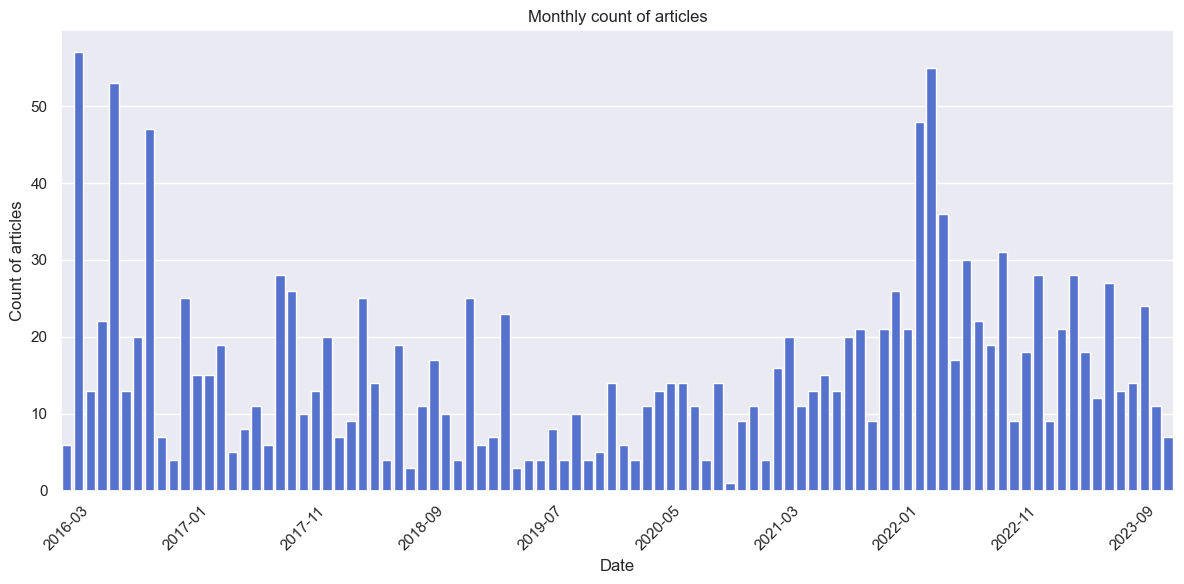

In [11]:
plot_timeseries_sb(summarized_news)

- From now we will focus on article that contains terms related to inflation based on the lexicon that we built

In [12]:
# check number of these news containing terms related to inflation
lexicon = pd.read_json('data/lexicon.json')['terms'].to_list()


# Apply the function to filter the DataFrame
summarized_news_filtered = summarized_news[summarized_news['New_text'].apply(lambda text: contains_lexicon_terms(text, lexicon))]

# Calculate the number of filtered news articles
number_of_filtered_news = len(summarized_news_filtered)

print(f'The number of news articles containing at least one term from the lexicon is: {number_of_filtered_news}')

The number of news articles containing at least one term from the lexicon is: 575


/Users/marc-antoineallard/opt/miniconda3/envs/DataScience/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/marc-antoineallard/opt/miniconda3/envs/DataScience/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/marc-antoineallard/opt/miniconda3/envs/DataScience/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


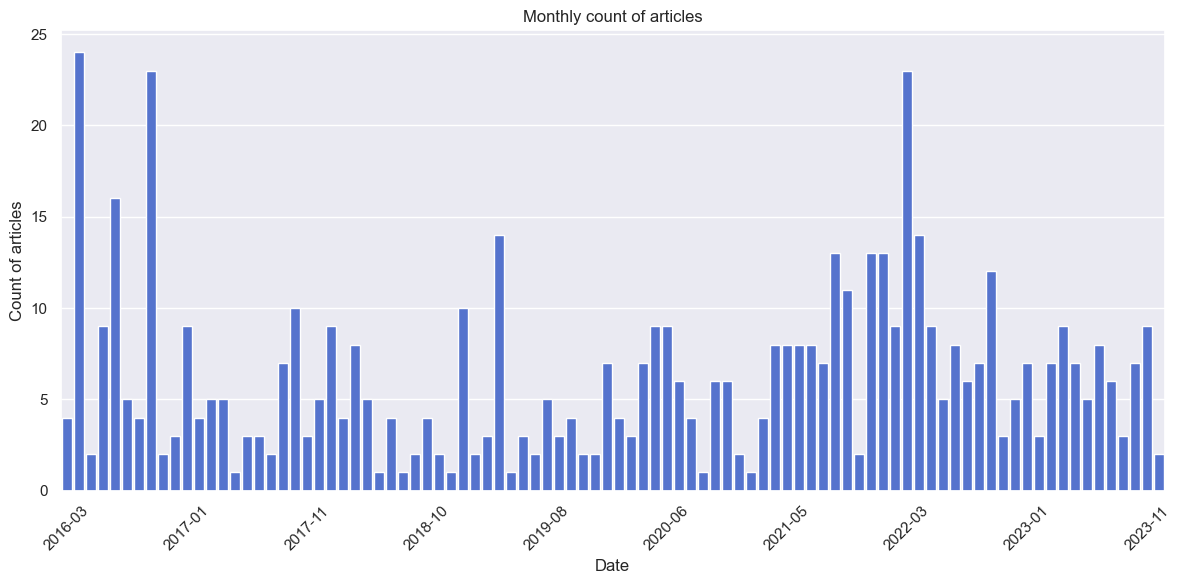

In [13]:
plot_timeseries_sb(summarized_news_filtered)

- Sentiment Distribution: 1 is negative, 2 is somewhat nega- tive, 3 is neutral, 4 is somewhat positive, 5 is positive

In [14]:
merged_news.describe()

,Mark,Sentiment_gpt
count,1502.0,1502.000000
mean,1.0,3.035952
std,0.0,0.934945
min,1.0,1.000000
25%,1.0,3.000000
50%,1.0,3.000000
75%,1.0,3.000000
max,1.0,5.000000


In [15]:
# Assuming your DataFrame is called 'df'
mapping = {1: -1, 2: 0, 3: 0, 4: 0, 5: 1}

# Create a new column with the mapped values
merged_news['Sentiment_gpt'] = merged_news['Sentiment_gpt'].map(mapping)

In [16]:
plot_sentiment(merged_news)

In [17]:
# Extract year and month
merged_news['YearMonth'] = pd.to_datetime(merged_news['Date']).dt.to_period('M')  # Assuming 'Date' is datetime format

# Group and calculate monthly sentiment sum
monthly_sum = merged_news.groupby('YearMonth')['Sentiment_gpt'].sum().reset_index()

In [18]:
plot_sentiment_evolution(merged_news)

In [19]:
# Calculate the 3-month rolling average
monthly_sum['Rolling_Sentiment'] = monthly_sum['Sentiment_gpt'].rolling(window=3).mean().fillna(0) 

monthly_sum['Cumsum'] =  monthly_sum['Sentiment_gpt'].cumsum()
monthly_sum['Pct_chge'] = monthly_sum['Cumsum'].pct_change().fillna(0).replace(-np.inf, 0)

monthly_sum['YearMonth'] = monthly_sum['YearMonth'].dt.to_timestamp()# Create a bar plot using pandas with the plotly backend

fig = monthly_sum.plot(kind='line', x='YearMonth', y='Rolling_Sentiment', title='Monthly Count of Sentiment-Labeled News Articles', backend='plotly')

    # Customize the layout for better readability
fig.update_layout(
    xaxis_title='Month',
    yaxis_title='Number of Articles',
    xaxis_tickformat='%Y-%m',
    xaxis_tickangle=-45
)

    # Show the plot
fig.show()

---
### 2. EDA 

#### 2.1 Exploration

In [20]:
path_2 = 'data/All_external.csv'

external_news = pd.read_csv(path_2, nrows=7000000)

oldest_date = external_news['Date'].min()
newest_date = external_news['Date'].max()

# Display the range of dates
print("Oldest Date:", oldest_date)
print("Newest Date:", newest_date)

Oldest Date: 1914-09-16 00:00:00 UTC
Newest Date: 2020-06-11 13:12:35 UTC


In [21]:
external_news['Date'] = pd.to_datetime(external_news['Date'])

# Filter rows to include only entries from 1999 or later
external_news_filtered = external_news[external_news['Date'].dt.year >= 1999]

# Display the range of dates after filtering
oldest_date_filtered = external_news_filtered['Date'].min()
newest_date_filtered = external_news_filtered['Date'].max()

print("Oldest Date after filtering:", oldest_date_filtered)
print("Newest Date after filtering:", newest_date_filtered)

# Display the yearly count of entries after filtering
yearly_counts_filtered = external_news_filtered['Date'].dt.year.value_counts().sort_index()
print("\nYearly Counts of News Entries after filtering:")
print(yearly_counts_filtered)

Oldest Date after filtering: 1999-08-31 00:00:00+00:00
Newest Date after filtering: 2020-06-11 13:12:35+00:00

Yearly Counts of News Entries after filtering:
Date
1999      3081
2000     16176
2001     21974
2002     22179
2003     21557
2004     24386
2005     30718
2006     35964
2007    170238
2008    449285
2009    359794
2010    478447
2011    657396
2012    639932
2013    508547
2014    580887
2015    810248
2016    520764
2017    344705
2018    523476
2019    578683
2020    201557
Name: count, dtype: int64


In [22]:
external_news_filtered.head()

,Date,Article_title,Stock_symbol,Url,Publisher,Author,Article,Lsa_summary,Luhn_summary,Textrank_summary,Lexrank_summary
0,2020-06-05 06:30:54+00:00,Stocks That Hit 52-Week Highs On Friday,A,https://www.benzinga.com/news/20/06/16190091/stocks-that-hit-52-week-highs-on-friday,Benzinga Insights,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-06-03 06:45:20+00:00,Stocks That Hit 52-Week Highs On Wednesday,A,https://www.benzinga.com/news/20/06/16170189/stocks-that-hit-52-week-highs-on-wednesday,Benzinga Insights,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-05-26 00:30:07+00:00,71 Biggest Movers From Friday,A,https://www.benzinga.com/news/20/05/16103463/71-biggest-movers-from-friday,Lisa Levin,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-05-22 08:45:06+00:00,46 Stocks Moving In Friday's Mid-Day Session,A,https://www.benzinga.com/news/20/05/16095921/46-stocks-moving-in-fridays-mid-day-session,Lisa Levin,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-05-22 07:38:59+00:00,"B of A Securities Maintains Neutral on Agilent Technologies, Raises Price Target to $88",A,https://www.benzinga.com/news/20/05/16095304/b-of-a-securities-maintains-neutral-on-agilent-technologies-raises-price-target-to-88,Vick Meyer,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
average_title_length = external_news_filtered['Article_title'].dropna().apply(lambda x: len(x.split())).mean()

# Display the average string length
print("Average String Length of Article Titles (in words):", average_title_length)

Average String Length of Article Titles (in words): 9.749702035416322


In [24]:
lexik = [
    "inflation",
    "Gasoline prices",
    "Food prices",
    "deflation", 
    "Consumer price index",
    "CPI",
    "Core CPI"
    ]

In [25]:
# Apply the function to filter the DataFrame
summarized_news_filtered = external_news_filtered[external_news_filtered['Article_title'].apply(lambda text: contains_lexicon_terms(text, lexik))]

# Calculate the number of filtered news articles
number_of_filtered_news = len(summarized_news_filtered)

print(f'The number of news articles containing at least one term from the lexicon is: {number_of_filtered_news}')

The number of news articles containing at least one term from the lexicon is: 12994


/Users/marc-antoineallard/opt/miniconda3/envs/DataScience/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead

/Users/marc-antoineallard/opt/miniconda3/envs/DataScience/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead

/Users/marc-antoineallard/opt/miniconda3/envs/DataScience/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead



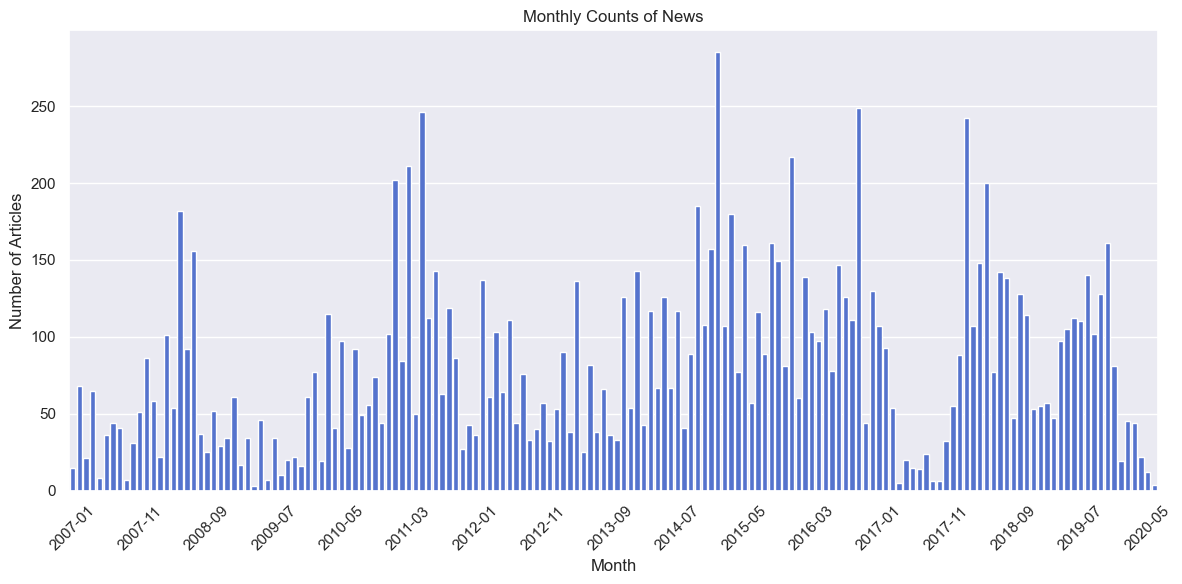

In [26]:
plot_timeseries_sb(summarized_news_filtered, title='Monthly Counts of News', x_title='Month', y_title='Number of Articles')

In [27]:
if len(summarized_news_filtered) > 0:
    print("Sample of 100 Titles containing 'inflation':")
    for title in summarized_news_filtered['Article_title'].sample(min(100, len(summarized_news_filtered))):
        print("-", title)
else:
    print("No titles found containing 'inflation'.")

Sample of 100 Titles containing 'inflation':
- CANADA FX DEBT-C$ steady but pressured by U.S. inflation data
- SanFran Fed sees core inflation holding below 2 pct
- Commodity Inflation May Trigger A Gold Rush
- Argentina 2016 inflation seen at 40 to 42 pct -finance minister
- U.S. Economic Week In Review: Strong Retail Sales And Modest Inflationary Pressures
- FED FOCUS-The coming Great Inflation, real or imagined
- UPDATE: Bernanke Says Fed is Not Printing Money with Asset Purchases, Fed Has Been Successful in Keeping Inflation Low; Inflation Expectations Have Stayed Low; Fed Has Wanted to Avoid Deflation
- General Mills, peers slide after sounding inflation alarm for food industry
- China inflation data fails to impress
- McCullough: Get Inflation Right, You Get The Bond Market Right
- UPDATE: Trichet Says Inflation to Decline Next Year, Stay Above 2% in Coming Months
- UMI Reports That Health Insurance Premium Inflation Shrank in 2014
- Japan Flash Manufacturing PMI Signals Intensif

In [28]:
# Path to the extracted CSV file
csv_file_path = 'data/nasdaq_external_data.csv'

columns_to_read = ['Date', 'Article_title', 'Url', 'Lsa_summary']

# Read the specified columns from the CSV file into a pandas DataFrame
nasdaq_data = pd.read_csv(csv_file_path, usecols=columns_to_read, nrows=5000000)

# Display the first few rows of the DataFrame to verify
nasdaq_data.head()

,Date,Article_title,Url,Lsa_summary
0,2023-12-16 23:00:00 UTC,Interesting A Put And Call Options For August 2024,https://www.nasdaq.com/articles/interesting-a-put-and-call-options-for-august-2024,"Because the $125.00 strike represents an approximate 10% discount to the current trading price of the stock (in other words it is out-of-the-money by that percentage), there is also the possibility that the put contract would expire worthless. Of course, a lot of upside could potentially be left on the table if A shares really soar, which is why looking at the trailing twelve month trading history for Agilent Technologies, Inc., as well as studying the business fundamentals becomes important. Below is a chart showing A's trailing twelve month trading history, with the $150.00 strike highlighted in red: Considering the fact that the $150.00 strike represents an approximate 8% premium to the current trading price of the stock (in other words it is out-of-the-money by that percentage), there is also the possibility that the covered call contract would expire worthless, in which case the investor would keep both their shares of stock and the premium collected."
1,2023-12-12 00:00:00 UTC,Wolfe Research Initiates Coverage of Agilent Technologies (A) with Outperform Recommendation,https://www.nasdaq.com/articles/wolfe-research-initiates-coverage-of-agilent-technologies-a-with-outperform-recommendation,"Fintel reports that on December 13, 2023, Wolfe Research initiated coverage of Agilent Technologies (NYSE:A) with a Outperform recommendation. Agilent instruments, software, services, solutions, and people provide trusted answers to customers' most challenging questions. Fintel is one of the most comprehensive investing research platforms available to individual investors, traders, financial advisors, and small hedge funds."
2,2023-12-12 00:00:00 UTC,Agilent Technologies Reaches Analyst Target Price,https://www.nasdaq.com/articles/agilent-technologies-reaches-analyst-target-price-0,"In recent trading, shares of Agilent Technologies, Inc. (Symbol: A) have crossed above the average analyst 12-month target price of $132.36, changing hands for $133.74/share. And so with A crossing above that average target price of $132.36/share, investors in A have been given a good signal to spend fresh time assessing the company and deciding for themselves: is $132.36 just one stop on the way to an even higher target, or has the valuation gotten stretched to the point where it is time to think about taking some chips off the table? The Top 25 Broker Analyst Picks of the S&P 500 » Also see:  PXMD Insider Buying  ETM Insider Buying  Funds Holding FXG The views and opinions expressed herein are the views and opinions of the author and do not necessarily reflect those of Nasdaq, Inc."
3,2023-12-07 00:00:00 UTC,Agilent (A) Enhances BioTek Cytation C10 With New Technology,https://www.nasdaq.com/articles/agilent-a-enhances-biotek-cytation-c10-with-new-technology,"Per a Grand View Research report, the global microplate reader market is expected to grow at a CAGR of 7.6% during the forecast period 2023-2030. A Mordor Intelligence report indicates the global live cell imaging market size will reach $2.95 billion by 2028, exhibiting a CAGR of 7.06% between 2023 and 2028. Some better-ranked stocks in the broader technology sector are Badger Meter BMI, Arista Networks ANET and Adobe ADBE."
4,2023-12-07 00:00:00 UTC,"Pre-Market Most Active for Dec 7, 2023 : SQQQ, PLTR, TQQQ, ALT, UBER, PFE, GILD, MRK, AMD, NIO, JBLU, AI",https://www.nasdaq.com/articles/pre-market-most-active-for-dec-7-2023-%3A-sqqq-pltr-tqqq-alt-uber-pfe-gild-mrk-amd-nio-jblu,"ProShares UltraPro Short QQQ (SQQQ) is -0.15 at $16.37, with 2,061,124 shares traded. Over the last four weeks they have had 6 up revisions for the earnings forecast, for the fiscal quarter ending Dec 2023. Over the last four weeks they have had 4 up revisions for the earnings forecast, for the fiscal quarter ending Mar 2024."


/Users/marc-antoineallard/opt/miniconda3/envs/DataScience/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead

/Users/marc-antoineallard/opt/miniconda3/envs/DataScience/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead

/Users/marc-antoineallard/opt/miniconda3/envs/DataScience/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead



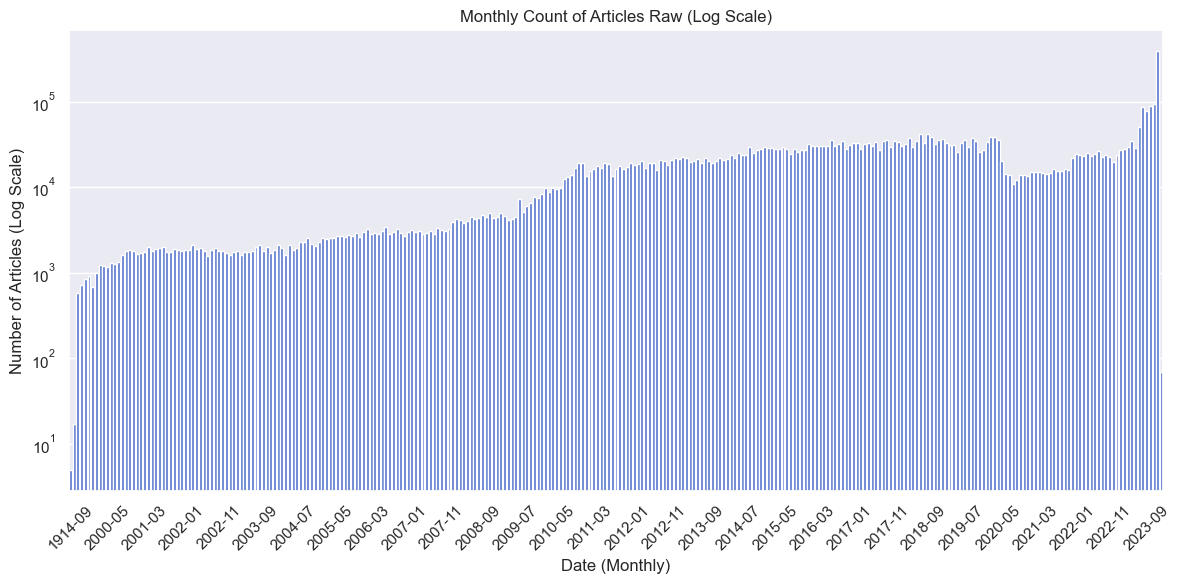

In [52]:
plot_timeseries_sb(
    nasdaq_data,
    title="Monthly Count of Articles Raw (Log Scale)",
    x_title="Date (Monthly)",
    y_title="Number of Articles (Log Scale)",
    log=True
)

In [30]:
nasdaq_data['Date'] = pd.to_datetime(nasdaq_data['Date'])

# Filter rows to include only entries from 1999 or later
nasdaq_data_filtered = nasdaq_data[nasdaq_data['Date'].dt.year >= 1999]


# Display the range of dates after filtering
oldest_date_filtered = nasdaq_data_filtered['Date'].min()
newest_date_filtered = nasdaq_data_filtered['Date'].max()

print("Oldest Date after filtering:", oldest_date_filtered)
print("Newest Date after filtering:", newest_date_filtered)

# Display the yearly count of entries after filtering
yearly_counts_filtered = nasdaq_data_filtered['Date'].dt.year.value_counts().sort_index()
print("\nYearly Counts of News Entries after filtering:")
print(yearly_counts_filtered)

Oldest Date after filtering: 1999-08-31 00:00:00+00:00
Newest Date after filtering: 2024-01-09 00:00:00+00:00

Yearly Counts of News Entries after filtering:
Date
1999      3081
2000     16176
2001     21974
2002     22179
2003     21557
2004     24386
2005     30718
2006     35964
2007     36029
2008     50389
2009     63683
2010    138419
2011    200698
2012    223860
2013    248428
2014    284477
2015    333381
2016    370436
2017    379784
2018    418133
2019    388108
2020    271971
2021    181623
2022    280354
2023    954117
2024        70
Name: count, dtype: int64


In [31]:
nasdaq_data_filtered.dropna(inplace=True)

In [32]:
# Apply the function to filter the DataFrame
titles_with_lexicon_terms = nasdaq_data_filtered[nasdaq_data_filtered['Lsa_summary'].apply(lambda text: contains_lexicon_terms(text, lexik))]

# Calculate the number of filtered news articles
num_titles_with_lexicon_terms = len(titles_with_lexicon_terms)

print(f'The number of news articles containing at least one term from the lexicon is: {num_titles_with_lexicon_terms}')

The number of news articles containing at least one term from the lexicon is: 74386


In [33]:
if len(titles_with_lexicon_terms) > 0:
    print("Sample of 100 Titles containing 'inflation':")
    for title in titles_with_lexicon_terms['Lsa_summary'].sample(min(3, len(titles_with_lexicon_terms))):
        print("-", title, '\n')
else:
    print("No titles found containing 'inflation'.")

Sample of 100 Titles containing 'inflation':
- By Echo Wang July 21 (Reuters) - The Nasdaq edged higher on Thursday boosted by gains in electric automaker Tesla on its better-than-expected quarterly results, which helped offset a slide in telecom and energy shares. Tesla TSLA.O surged 10.1%, while AT&T Inc T.N tumbled to bring down telecom shares after the wireless carrier cut its cash flow forecast saying some subscribers were delaying bill payments. Rising inflation also led the European Central Bank to belatedly join global peers in a rate-hike cycle with an aggressive 50-basis point increase. 

- Gold and gold mining stocks rose, with the VanEck Vectors Gold Miners ETF (NYSEMKT: GDX)  up 1.4%. Stocks made gains on Thursday after the Labor Department reported that consumer prices rose less than expected in April, easing worries about inflation. Ubiquiti reversed a decline in gross margin last quarter that was caused by disappointing sales of a newly released consumer product. 

- By

/Users/marc-antoineallard/opt/miniconda3/envs/DataScience/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead

/Users/marc-antoineallard/opt/miniconda3/envs/DataScience/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead

/Users/marc-antoineallard/opt/miniconda3/envs/DataScience/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead



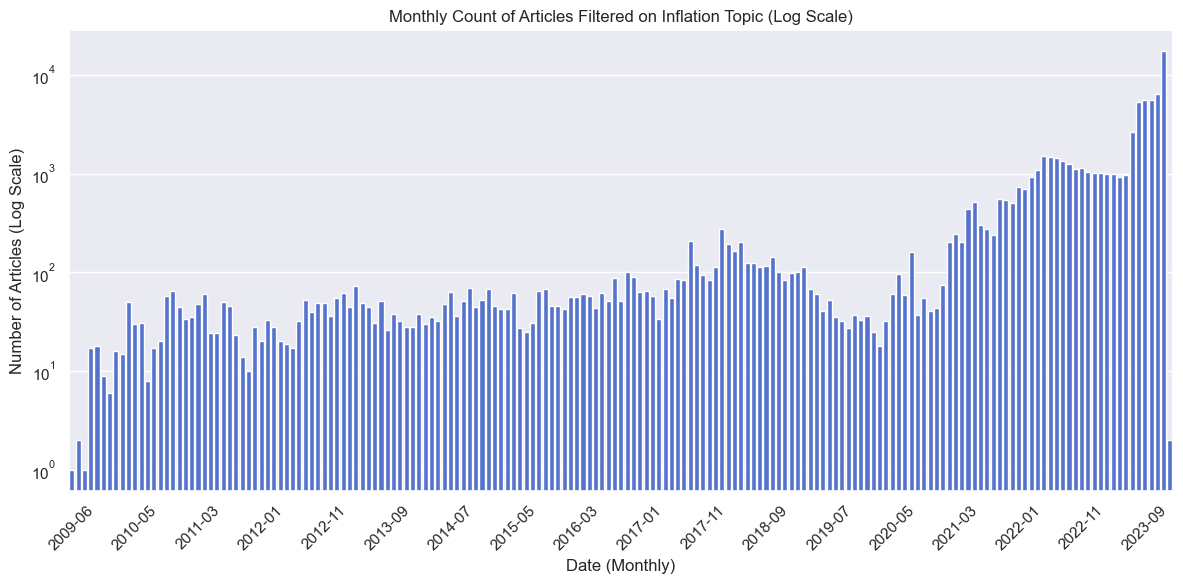

In [51]:
plot_timeseries_sb(
    titles_with_lexicon_terms,
    title="Monthly Count of Articles Filtered on Inflation Topic (Log Scale)",
    x_title="Date (Monthly)",
    y_title="Number of Articles (Log Scale)",
    log=True
)

In [35]:
# Filter news where 'Lsa_summary' has word count > 100
nasdaq_news = filter_by_summary_length(titles_with_lexicon_terms.copy(), min_word_count=100)

len(nasdaq_news)

40590

In [36]:
nasdaq_news = filter_by_month(nasdaq_news, max_entries=20)
plot_timeseries(nasdaq_news)

/var/folders/gx/b0gl84xd4rjflbpgs2bhddcc0000gp/T/ipykernel_22298/1451904340.py:145: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



/Users/marc-antoineallard/opt/miniconda3/envs/DataScience/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead

/Users/marc-antoineallard/opt/miniconda3/envs/DataScience/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead

/Users/marc-antoineallard/opt/miniconda3/envs/DataScience/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead



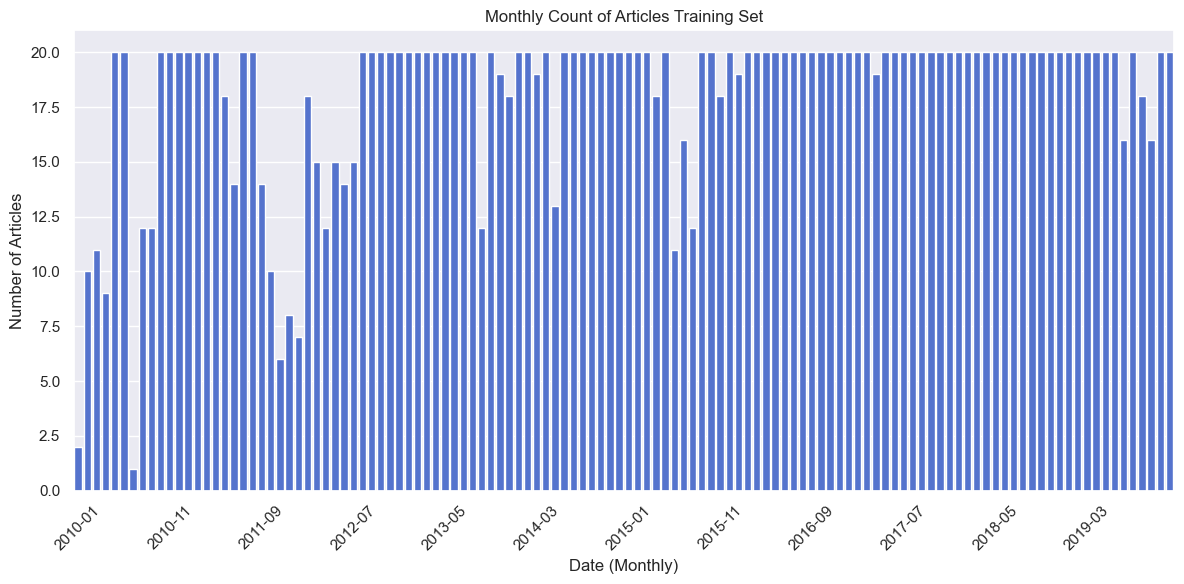

In [53]:
plot_timeseries_sb(
    nasdaq_news,
    title="Monthly Count of Articles Training Set",
    x_title="Date (Monthly)",
    y_title="Number of Articles"
)

In [55]:
nasdaq_news_count = nasdaq_news['Date'].dt.year.value_counts().sort_index()
print("\nYearly Counts of News Entries after filtering:")
print(nasdaq_news_count)


Yearly Counts of News Entries after filtering:
Date
2010    157
2011    190
2012    196
2013    229
2014    232
2015    215
2016    239
2017    239
2018    240
2019    230
Name: count, dtype: int64


- We drop 2009

In [39]:
nasdaq_news = nasdaq_news[nasdaq_news['Date'].dt.year >= 2010]
nasdaq_news = nasdaq_news[nasdaq_news['Date'].dt.year <= 2019]

nasdaq_news_count = nasdaq_news['Date'].dt.year.value_counts().sort_index()
print("\nYearly Counts of News Entries after filtering:")
print(nasdaq_news_count)
print("-----------")
print(f"Final size clean dataset: {len(nasdaq_news)}")


Yearly Counts of News Entries after filtering:
Date
2010    157
2011    190
2012    196
2013    229
2014    232
2015    215
2016    239
2017    239
2018    240
2019    230
Name: count, dtype: int64
-----------
Final size clean dataset: 2167


In [40]:
nasdaq_news = nasdaq_news.rename(columns={'Lsa_summary': 'Summary'})[['Date', 'Summary']]

In [41]:
nasdaq_news.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2167 entries, 28 to 2194
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype              
---  ------   --------------  -----              
 0   Date     2167 non-null   datetime64[ns, UTC]
 1   Summary  2167 non-null   object             
dtypes: datetime64[ns, UTC](1), object(1)
memory usage: 50.8+ KB


In [42]:
nasdaq_news['label'] = nasdaq_news.apply(lambda x: 0)

In [43]:
# nasdaq_news.to_parquet('data/nasdaq_news_index_2010_2023.parquet')

In [44]:

nasdaq_news_count = nasdaq_news['Date'].dt.year.value_counts().sort_index()
print("\nYearly Counts of News Entries train split:")
print(nasdaq_news_count)
print("-----------")
print(f"Final size clean dataset: {len(nasdaq_news)}")


Yearly Counts of News Entries train split:
Date
2010    157
2011    190
2012    196
2013    229
2014    232
2015    215
2016    239
2017    239
2018    240
2019    230
Name: count, dtype: int64
-----------
Final size clean dataset: 2167


---
**Prompt for GPT labelling:**

Here is a financial news article related to inflation. Please read the article and determine whether it expresses a sentiment that inflation will go up, go down, or if it makes no clear expression. Use any financial knowledge you have.

Respond with a SINGLE number (no explanation needed):

- 1 if the article expresses inflation will go up.
- -1 if the article expresses inflation will go down.
- 0 if the article sentiment about inflation is neutral.

Here's the article:

[Insert the text of the article here]


---